In [1]:
import gymnasium

In [2]:
from gymnasium import envs

list(envs.registry.keys())

['CartPole-v0',
 'CartPole-v1',
 'MountainCar-v0',
 'MountainCarContinuous-v0',
 'Pendulum-v1',
 'Acrobot-v1',
 'phys2d/CartPole-v0',
 'phys2d/CartPole-v1',
 'phys2d/Pendulum-v0',
 'LunarLander-v2',
 'LunarLanderContinuous-v2',
 'BipedalWalker-v3',
 'BipedalWalkerHardcore-v3',
 'CarRacing-v2',
 'Blackjack-v1',
 'FrozenLake-v1',
 'FrozenLake8x8-v1',
 'CliffWalking-v0',
 'Taxi-v3',
 'tabular/Blackjack-v0',
 'tabular/CliffWalking-v0',
 'Reacher-v2',
 'Reacher-v4',
 'Pusher-v2',
 'Pusher-v4',
 'InvertedPendulum-v2',
 'InvertedPendulum-v4',
 'InvertedDoublePendulum-v2',
 'InvertedDoublePendulum-v4',
 'HalfCheetah-v2',
 'HalfCheetah-v3',
 'HalfCheetah-v4',
 'Hopper-v2',
 'Hopper-v3',
 'Hopper-v4',
 'Swimmer-v2',
 'Swimmer-v3',
 'Swimmer-v4',
 'Walker2d-v2',
 'Walker2d-v3',
 'Walker2d-v4',
 'Ant-v2',
 'Ant-v3',
 'Ant-v4',
 'Humanoid-v2',
 'Humanoid-v3',
 'Humanoid-v4',
 'HumanoidStandup-v2',
 'HumanoidStandup-v4',
 'GymV21Environment-v0',
 'GymV26Environment-v0']

In [3]:
env = gymnasium.make('CartPole-v1')

有关 CartPole 这个环境的文档可以参见[这里](https://gymnasium.farama.org/environments/classic_control/cart_pole/)


In [4]:
state1 = env.reset()
action = env.action_space.sample()
state, reward, terminated, truncated, info = env.step(action)

In [5]:
state1

(array([ 0.03734683,  0.04601932, -0.01780077, -0.01990016], dtype=float32),
 {})

`reset` 方法用于重置环境并返回第一个状态，最新版本的 gymnasium 的 api 和大部分教材都不一样，这需要注意。有关 `env` 的文档可以参见[这里](https://gymnasium.farama.org/api/env/#gymnasium.Env.step)

In [6]:
state, reward, terminated, truncated, info

(array([ 0.03826722, -0.14884289, -0.01819877,  0.2671137 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [7]:
import torch

In [8]:
l1 = 4   # size of state space is 4
l2 = 150 # hidden layer
l3 = 2   # size of action space

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax()
)

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def discount_rewards(rewards, gamma=0.99):
	lenr = len(rewards)
	disc_return = torch.pow(gamma, torch.arange(lenr).float()) * rewards
	# normalize rewards to be within [0, 1] to improve numerical stability
	disc_return /= disc_return.max()
	return disc_return

In [10]:
def loss_fn(preds, r):
	return -1 * torch.sum(r * torch.log(preds))

In [11]:
import numpy as np

MAX_DUR = 200
MAX_EPISODES = 2000
gamma = 0.99
score = []
for episode in range(MAX_EPISODES):
    curr_state, info = env.reset()
    done = False
    transitions = []

    for t in range(MAX_DUR):
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0, 1]), p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, _, terminated, truncated, info = env.step(action)
        transitions.append((prev_state, action, t+1))

        if terminated or truncated:
            break

    ep_len = len(transitions)
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,))
    disc_rewards = discount_rewards(reward_batch)
    state_batch = torch.Tensor([s for (s, a, r) in transitions]) 
    action_batch = torch.Tensor([a for (s, a, r) in transitions]) 
    # recomputes the action probabilities for all the states in the episode
    pred_batch = model(state_batch)
    # subsets the action-probabilities associated with the actions that were actually taken
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1, 1)).squeeze()
    loss = loss_fn(prob_batch, disc_rewards)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/var/folders/63/hmm24s352qv_4vs09n66p97m0000gn/T/ipykernel_88708/1603912446.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  state_batch = torch.Tensor([s for (s, a, r) in transitions])


In [12]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

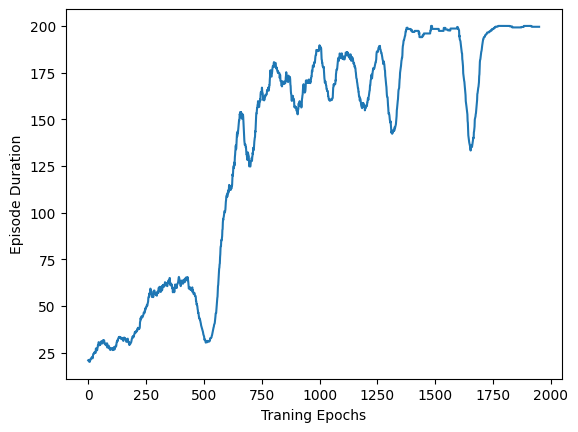

In [13]:
import matplotlib.pyplot as plt

avg_score = running_mean(np.array(score), 50)
plt.ylabel("Episode Duration")
plt.xlabel("Traning Epochs")
plt.plot(avg_score)

/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


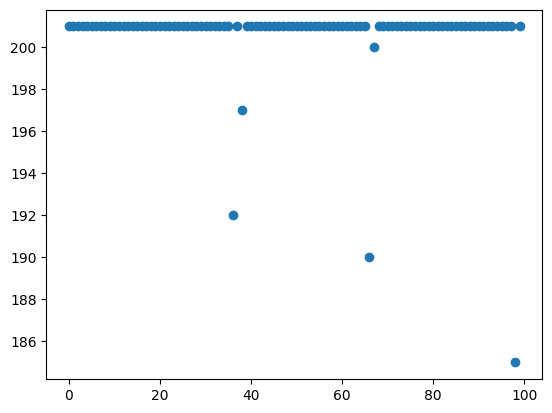

In [14]:
def test_model(model):
    score = []
    games = 100
    state1, info = env.reset()
    truncated = False
    terminated = False

    for i in range(games):
        t = 0
        while not (truncated or terminated):
            pred = model(torch.from_numpy(state1).float())
            action = np.random.choice(np.array([0, 1]), p=pred.data.numpy())
            state2, reward, terminated, truncated, info = env.step(action)
            state1 = state2
            t += 1
            if t > MAX_DUR:
                break

        state1, info = env.reset()
        terminated = False
        truncated = False
        score.append(t)

    return score

history = test_model(model)
plt.scatter(np.arange(len(history)), np.array(history))